<a href="https://colab.research.google.com/github/AchmadBauravindah/simple-PCA/blob/master/Simple_PCA_2D_(Image)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Proses PCA dibagi menjadi 3 tahapan (poin) utama yaitu:

1. Split data dengan K-Fold
2. Proses PCA (mengambil bobot dan proyeksi matriks dari data train)
3. Proses Testing dan hasil akurasi

Tahapan lengkapnya (PCA) ada dibawah ini:
1. Import data image dari github
2. Membagi dataset menjadi data train dan test dengan K-Fold
3. Proses PCA, mengambil bobot dan proyeksi matriks dari data training
4. Menghitung bobot data test
5. Menghitung jarak dari bobot data test dengan data train
6. Mencari posisi data test (orang ke, pose ke)
7. Menghitung akurasi dari posisi data test dengan data asli


PCA 2D: digunakan untuk mengatasi masalah pada PCA 1D
Apa masalahnya?
- Jika jumlah data yang dimiliki lebih besar daripada jumlah pixel yang dibuat 1D, maka perhitungan kovarian menimbulkan perhitungan yang lebih besar
- Jadi kovarian yang didapatkan memiliki shape matrix yang lebih banyak daripada shape matrix image yang sudah di flatten

# Import image from Github

In [1]:
_ = !git clone https://github.com/AchmadBauravindah/datas_for_ai.git

In [2]:
import cv2 # Untuk mengambil pixel dari image
import pandas as pd # Membantu membuat dataframe
import numpy as np # Membantu proses operasi matriks dan matematika
from sklearn.model_selection import KFold # Membantu split data sebanyak k fold
from sklearn.metrics.pairwise import manhattan_distances # Membantu mencari jarak manhattan
import math # Membantu proses operasi matematika
import matplotlib.pyplot as plt

# 1. K-Fold

In [3]:
# K-FOLD
path = "datas_for_ai/biometrika/orl_face/"

def k_fold_split():
  jumlah_orang = 40 # Jumlah orang pada data orl
  jumlah_pose = 10 # Jumlah pose pada data orl

  nama_file_depan = 'ORL_'
  nama_file_belakang = '.jpg'

  dataset_train_face = [] # Menyimpan matriks data train semua fold
  dataset_test_face = [] # Menyimpan matriks data test semua fold

  kf = KFold(n_splits=5) # Menentukan jumlah fold

  split_pose = np.linspace(1, 10, 10) # Membuat array untuk identifier indeks pose

  fold_ke = 1
  for train_i, test_i in kf.split(split_pose): # Proses K-FOLD
    print("Indeks Fold Ke - {}".format(fold_ke), train_i, test_i)
    fold_ke +=1
    # Agar indeks mulai dari 1
    train_i = train_i + 1
    test_i = test_i + 1
    train_face = [] # Menyimpan data train per fold
    test_face = [] # Menyimpan data test per fold
    for orang_ke in np.linspace(1, 40, 40).astype(np.int8): # Orang (40 Orang)
      for pose_ke in np.linspace(1, 10, 10).astype(np.int8): # Pose (10 Pose)
        if pose_ke in train_i:
          nama_file = nama_file_depan + str(orang_ke) + '_' + str(pose_ke) + nama_file_belakang
          nama_file = path + nama_file
          img = cv2.imread(nama_file, 0)
          # print("Shape of image", img.shape)
          train_face.append(img)
        else:
          nama_file = nama_file_depan + str(orang_ke) + '_' + str(pose_ke) + nama_file_belakang
          nama_file = path + nama_file
          img = cv2.imread(nama_file, 0)
          # print("Shape of image", img.shape)
          test_face.append(img)
    dataset_train_face.append(train_face)
    dataset_test_face.append(test_face)
  return dataset_train_face, dataset_test_face
        

### Proses split dataset sebanyak 5 Fold

In [4]:
train, test = k_fold_split()

Indeks Fold Ke - 1 [2 3 4 5 6 7 8 9] [0 1]
Indeks Fold Ke - 2 [0 1 4 5 6 7 8 9] [2 3]
Indeks Fold Ke - 3 [0 1 2 3 6 7 8 9] [4 5]
Indeks Fold Ke - 4 [0 1 2 3 4 5 8 9] [6 7]
Indeks Fold Ke - 5 [0 1 2 3 4 5 6 7] [8 9]


# 2. PCA (2D Image)

In [5]:
def PCA(data):
  # 1. Ukuran Data
  (n_images, n_Xpixel, n_Ypixel) = data.shape # (jumlah image, jumlah pixel image pada axis x, jumlah pixel image pada axis y)
  n_images = int(n_images)
  n_Xpixel = int(n_Xpixel)
  n_Ypixel = int(n_Ypixel)
  # 2. Hitung Rata-rata
  addition_image = 0
  for i in range(n_images):
    addition_image = np.add(addition_image, data[i])
  average = addition_image / n_images
  # 3. Hitung Kovarian dengan tiap Zero Mean pada image
  cov_matrix = 0
  for i in range(n_images):
    image = data[i]
    zero_mean = image - average
    cov_matrix = cov_matrix + (np.transpose(zero_mean) @ zero_mean)

  # 5. Hitung eigen vektor dan eigen value
  [eigen_value, eigen_vector] = np.linalg.eig(cov_matrix)
  
  # Proses Sorting (Mengurutkan eigen vektor dari yang terbesar)
  idx = np.argsort(eigen_value)[::-1]
  eigen_value = eigen_value[idx]
  eigen_vector = eigen_vector[:,idx]

  # 6. Hitung Proyeksi Matriks
  matrix_projection = eigen_vector
  
  # 7. Hitung Matrix Bobot
  matrix_weights = []
  for i in range(n_images):
    image = data[i]
    matrix_weight = image @ eigen_vector
    matrix_weights.append(matrix_weight)
  matrix_weights = np.array(matrix_weights)

#   print("Zero Mean : ", zero_mean.shape) # (112, 92)
#   print("Kovarian : ", cov_matrix.shape) # (92, 92)
#   print("Eigen Value : ", eigen_value.shape) # (92,)
#   print("Eigen Vektor : ", eigen_vector.shape) # (92, 92)
#   print("Proyeksi Matriks : ", matrix_projection.shape) # (92, 92)
#   print("Bobot Matriks semua image : ", matrix_weights.shape) # (320, 112, 92)
  return matrix_projection, matrix_weights

# 3. Proses Testing dan Hasil Akurasi

### - Mendapatkan Weight Data Test
*weight data test = data test * transpose(proyeksi matriks data train)*


In [6]:
def getWeightDataTest(data_test, projection_matrices):
  weight = data_test @ np.transpose(projection_matrices) # PERLU DIPERTANYAKAN "PROYEKSI MATRIKS (92X92) APA PERLU DI TRANSPOSE?"
  return weight # keluaranya matrix 112 X 92

### - Mendapatkan jarak terdekat dari data test

##### Manhattan

In [7]:
def myManhattan(data_test, data_train):
  result = np.abs(data_test - data_train).sum()
  return result

In [8]:
def getManhattanDistances(data_test_weight, data_train_weights):
  manhattan_result = []
  
  for data_train_weight in data_train_weights:
    hasil = myManhattan(data_test_weight, data_train_weight)
    manhattan_result.append(hasil)
  return manhattan_result

##### Euclidean

In [9]:
def myEuclidean(data_test, data_train):
  result = np.power((data_test - data_train), 2).sum()
  result = np.sqrt(result)
  return result

In [10]:
def getEuclideanDistances(data_test_weight, data_train_weights):
  manhattan_result = []
  
  for data_train_weight in data_train_weights:
    hasil = myManhattan(data_test_weight, data_train_weight)
    manhattan_result.append(hasil)
  return manhattan_result

### - Mendapatkan jarak minimum dari hasil jarak terdekat
*jarak minimum = min(jarak)*

In [11]:
def getMinimumIndexDistances(distances):
    minimum_index_distances = np.argmin(distances)
    return minimum_index_distances

### - Mendapatkan posisi image data test

*posisi image = orang ke, pose ke*

In [12]:
def getPositionImage(distances):
  jumlah_pose = 8 # setelah di fold data menjadi 8 pose
  baris_ke = getMinimumIndexDistances(distances) # Baris ke berapa dalam dataset 320 itu
  orang_ke = int(math.ceil(baris_ke/jumlah_pose)) # 0.1 atau 0.9 akan menjadi 1 karena math.ceil
  pose_ke = np.mod(baris_ke, jumlah_pose) # Pose ke berapa dalam 8 pose tiap orang itu
  if pose_ke == 0:
    pose_ke = jumlah_pose
  return orang_ke, pose_ke

### - Proses testing PCA
*PCA Results akan menghasilkan posisi image pada data test*

In [13]:
def testingPCAEuclidean(data_tests, data_train_projection, data_train_weights):
  PCA_Results = []

  # Mengambil Data Test fold ke-5
  for data_test in data_tests:
    # Mendapatkan weight dari data test
    data_test_weight = getWeightDataTest(data_test, data_train_projection)
    # distance : weight data test (1x320) - weight data train (320x320)
    distances = getEuclideanDistances(data_test_weight, data_train_weights)

    # Menghitung jarak terdekat
    orang_ke, pose_ke = getPositionImage(distances)
    PCA_Results.append([orang_ke, pose_ke])

  PCA_Results = np.array(PCA_Results)
  return PCA_Results # Array dari Orang Ke, Pose Ke

In [14]:
def testingPCAManhattan(data_tests, data_train_projection, data_train_weights):
  PCA_Results = []

  # Mengambil Data Test fold ke-5
  for data_test in data_tests:
    # Mendapatkan weight dari data test
    data_test_weight = getWeightDataTest(data_test, data_train_projection)
    # distance : weight data test (1x320) - weight data train (320x320)
    distances = getManhattanDistances(data_test_weight, data_train_weights)

    # Menghitung jarak terdekat
    orang_ke, pose_ke = getPositionImage(distances)
    PCA_Results.append([orang_ke, pose_ke])

  PCA_Results = np.array(PCA_Results)
  return PCA_Results # Array dari Orang Ke, Pose Ke

### - Mendapatkan Hasil Akurasi PCA semua Fold (5 Fold)
*Mendapatkan akurasi dari hasil testing*

In [15]:
def getAccuracyPCA(hasil_test_PCA):
  # Membuat array untuk kelas asli, jika di data test ada 2 pose maka kelas ke-1 memiliki 2 pose (1, 1)
  kelas_asli = (np.linspace(1, 40, 40).astype(int))
  kelas_asli = np.repeat(kelas_asli, 2)

  # Mendapatkan hasil kelas (orang_ke) apa dari hasil PCA
  kelas_test = hasil_test_PCA[:, [0]]
  kelas_test = kelas_test.reshape(1, -1)[0]
  akurasi = (((kelas_asli == kelas_test).sum()) / np.size(kelas_asli)) * 100
  return akurasi

*Mendapatkan hasil PCA semua Fold (5 Fold)*

In [16]:
def testingResultPCA(method):
  hasil_test_PCA_semua_fold = [] # array untuk simpan hasil PCA tiap fold
  i = 0
  for data_train_per_fold, data_test_per_fold in zip(train, test):
    i+=1
    print("Proses testing Fold-{}".format(i))
    data_train = np.array(data_train_per_fold) # Ubah list biasa menjadi list numpy
    data_test = np.array(data_test_per_fold) # Ubah list biasa menjadi list numpy

    projection_train, weight_train = PCA(data_train) # Mendapatkan proyeksi dan bobot data train
    # Memilih metode untuk mencari jarak
    if method == "euclidean":
      hasil_test_PCA = testingPCAEuclidean(data_test, projection_train, weight_train) # Mendapatkan hasil PCA yang berisi array orang_ke, pose_ke
    else:
      hasil_test_PCA = testingPCAManhattan(data_test, projection_train, weight_train) # Mendapatkan hasil PCA yang berisi array orang_ke, pose_ke
    hasil_test_PCA_semua_fold.append(hasil_test_PCA) # Menyimpan hasil PCA data test
    print("Shape (bobot train): {}".format(weight_train.shape))
    print("\n")
  return hasil_test_PCA_semua_fold

In [17]:
euclidean_PCA = testingResultPCA("euclidean")
manhattan_PCA = testingResultPCA("manhattan")

Proses testing Fold-1
Shape (bobot train): (320, 112, 92)


Proses testing Fold-2
Shape (bobot train): (320, 112, 92)


Proses testing Fold-3
Shape (bobot train): (320, 112, 92)


Proses testing Fold-4
Shape (bobot train): (320, 112, 92)


Proses testing Fold-5
Shape (bobot train): (320, 112, 92)


Proses testing Fold-1
Shape (bobot train): (320, 112, 92)


Proses testing Fold-2
Shape (bobot train): (320, 112, 92)


Proses testing Fold-3
Shape (bobot train): (320, 112, 92)


Proses testing Fold-4
Shape (bobot train): (320, 112, 92)


Proses testing Fold-5
Shape (bobot train): (320, 112, 92)




*Menampilkan hasil akurasi PCA semua Fold (5 Fold)*

##### Akurasi Euclidean 

Akurasi fold Ke- 1 =  2.5 %
Akurasi fold Ke- 2 =  2.5 %
Akurasi fold Ke- 3 =  1.25 %
Akurasi fold Ke- 4 =  0.0 %
Akurasi fold Ke- 5 =  2.5 %


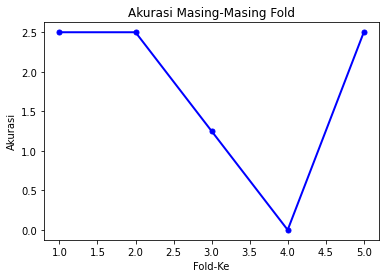

In [18]:
fold = 1
fold_graph = []
accuracy_val_graph = []
hasil_test_PCA_semua_fold = euclidean_PCA
for hasil_test_PCA_per_fold in hasil_test_PCA_semua_fold:
  print("Akurasi fold Ke- {} = ".format(fold), getAccuracyPCA(hasil_test_PCA_per_fold), "%")
  accuracy_val_graph.append(getAccuracyPCA(hasil_test_PCA_per_fold))
  fold_graph.append(fold)
  fold+=1  

plt.plot(fold_graph, accuracy_val_graph, color='blue', marker='o', linestyle='-',
     linewidth=2, markersize=5)
plt.xlabel("Fold-Ke")
plt.ylabel("Akurasi")
plt.title("Akurasi Masing-Masing Fold")
plt.show()


##### Akurasi Manhattan 


Akurasi fold Ke- 1 =  2.5 %
Akurasi fold Ke- 2 =  2.5 %
Akurasi fold Ke- 3 =  1.25 %
Akurasi fold Ke- 4 =  0.0 %
Akurasi fold Ke- 5 =  2.5 %


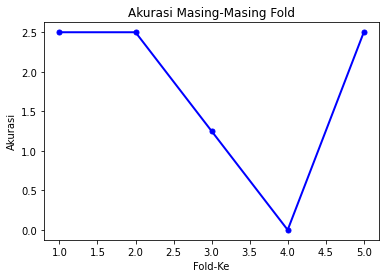

In [19]:
fold = 1
fold_graph = []
accuracy_val_graph = []
hasil_test_PCA_semua_fold = manhattan_PCA
for hasil_test_PCA_per_fold in hasil_test_PCA_semua_fold:
  print("Akurasi fold Ke- {} = ".format(fold), getAccuracyPCA(hasil_test_PCA_per_fold), "%")
  accuracy_val_graph.append(getAccuracyPCA(hasil_test_PCA_per_fold))
  fold_graph.append(fold)
  fold+=1  

plt.plot(fold_graph, accuracy_val_graph, color='blue', marker='o', linestyle='-',
     linewidth=2, markersize=5)
plt.xlabel("Fold-Ke")
plt.ylabel("Akurasi")
plt.title("Akurasi Masing-Masing Fold")
plt.show()


### Mendapatkan image dari orang ke, pose ke

In [20]:
def getImage(orang_ke, pose_ke):
  nama_file_depan = 'ORL_'
  nama_file_belakang = '.jpg'
  nama_file = nama_file_depan + str(orang_ke) + '_' + str(pose_ke) + nama_file_belakang
  nama_file = path + nama_file
  img = cv2.imread(nama_file, 0)
  return img

### Menampilkan semua perbandigan image asli dan prediksi pada Fold-5

NameError: ignored

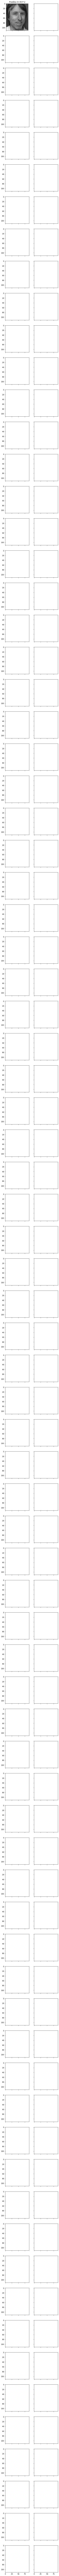

In [21]:
from operator import index
import sys
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image

hasil_test_PCA_fold_5 = hasil_test_PCA_semua_fold[4]

fig, axes = plt.subplots(80, 2, sharex=True, sharey=True, figsize=(6,300))

iterasi = np.linspace(0,79,79)
index_data_prediksi = np.linspace(0,79,79)
index_data_asli = np.repeat(np.linspace(1,40,40), 2)

for i, i_pred, i_asli in zip(iterasi, index_data_prediksi, index_data_asli):
  i = int(i)
  i_pred = int(i_pred)
  i_asli = int(i_asli)
  # Image Test
  orang_ke = hasil_test_PCA_fold_5[(i_pred)][0]
  pose_ke = hasil_test_PCA_fold_5[i_pred][1]

  image = getImage(orang_ke, pose_ke)
  axes[i][0].imshow(image, cmap=plt.get_cmap('gray'))
  axes[i][0].set_title('Prediksi O-{} P-{}'.format(orang_ke, pose_ke))

  # Image Asli
  image = data_test[i]
  orang_ke = i_asli
  pose_ke = 9 # pose yang ada pada data asli hanya pose 9 dan 10 karena data test dengan k-fold yang terakhir
  if i % 2 == 1:
    pose_ke = 10
  axes[i][1].imshow(image, cmap=plt.get_cmap('gray'))
  axes[i][1].set_title('Asli O-{} P-{}'.format(orang_ke, pose_ke))